In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle
import joblib

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


In [13]:
# load data
with open('../data/train_data.pkl', 'rb') as f:
    X_train, y_train, column_names = pickle.load(f)
with open('../data/validation_data.pkl', 'rb') as f:
    X_val, y_val, column_names = pickle.load(f)
with open('../data/test_data.pkl', 'rb') as f:
    X_test, y_test, column_names = pickle.load(f)

# Dummy mean model

In [14]:
performances = []

In [15]:
# Calculate the mean value of the training set responses
mean_value = y_train.mean()

# Define the model name for easy reference
model_name = 'mean'

# Loop through each dataset (training, validation, test)
for y, nsplit in zip([y_train, y_val, y_test], ['train', 'val', 'test']):
    # Create an array filled with the mean value for predictions
    mean_predictions = [mean_value] * y.shape[0]
    
    # Calculate the RMSE using the true values and the constant mean predictions
    rmse = np.sqrt(mean_squared_error(y, mean_predictions))
    
    # Calculate the R2 score using the true values and the constant mean predictions
    r2 = r2_score(y, mean_predictions)
    
    # Calculate the MAE using the true values and the constant mean predictions
    mae = mean_absolute_error(y, mean_predictions)
    
    # Append the performance metrics to the list
    performances.append({
        'model': model_name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'r2': r2.round(4)
    })

# Linear model

In [16]:
# # Load and fit model
# reg = LinearRegression().fit(X_train, y_train)
# # Zip data and labels
# for x,y,nsplit in zip([X_train, X_val, X_test],
#                     [y_train, y_val, y_test],
#                     ['train', 'val', 'test']): 
#     # get predictions                
#     preds = reg.predict(x)
#     # Get r2 value
#     r2 = r2_score(y, preds)
#     # Get RMSE
#     performance = np.sqrt(mean_squared_error(y, preds))
#     # Append
#     performances.append({'model': 'linear',
#                          'split': nsplit,
#                          'rmse': performance.round(4),
#                          'r2': r2.round(4)})

# KNN model

In [17]:
for k in [5, 10, 20, 30, 100]:  # Choosing number of neighbors
    # Load model
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit model
    knn.fit(X_train, y_train)
    # Zip data and labels
    for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
        # Make predictions                
        preds = knn.predict(x)
        # Get r2 score
        r2 = r2_score(y, preds)
        # Get RMSE
        rmse = np.sqrt(mean_squared_error(y, preds))
        # Get MAE
        mae = mean_absolute_error(y, preds)
        # Append to performances
        performances.append({
            'model': f'KNN-{k}',
            'split': nsplit,
            'rmse': rmse.round(4),
            'mae': mae.round(4),
            'r2': r2.round(4)
        })

# Plotting

In [18]:
#Turn into pddf
perf_df = pd.DataFrame(performances)

# R^2

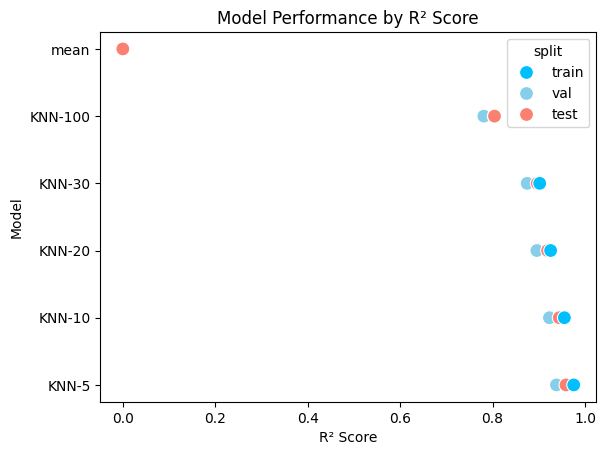

In [19]:
# Make scatterplot of r2
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                     y='model', 
                     x='r2', 
                     marker='o',   # Circle markers
                     s=100,        # Size of the markers
                     hue='split',  # Color by split
                     palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by R² Score')

# Adding x and y axis labels
plt.xlabel('R² Score')
plt.ylabel('Model')
# Save plot
plt.savefig(('../plots/base_models_R2.png'))
# Display the plot
plt.show()

# RMSE 

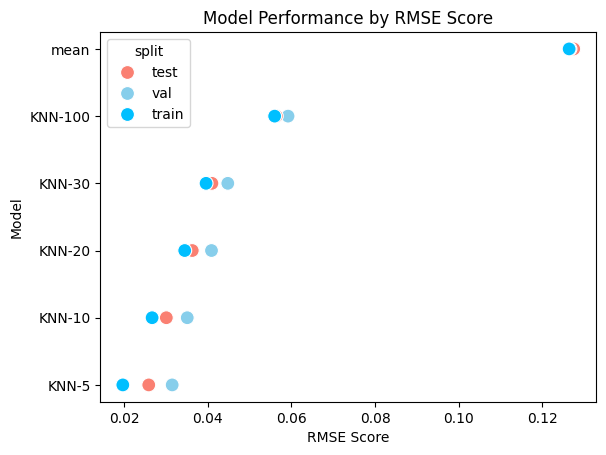

In [20]:
# Make scatterplot of rmse
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                     y='model', 
                     x='rmse', 
                     marker='o',   # Circle markers
                     s=100,        # Size of the markers
                     hue='split',  # Color by split
                     palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by RMSE Score')

# Adding x and y axis labels
plt.xlabel('RMSE Score')
plt.ylabel('Model')
# Save plot
plt.savefig(('../plots/base_models_RMSE.png'))
# Display the plot
plt.show()

# MAE

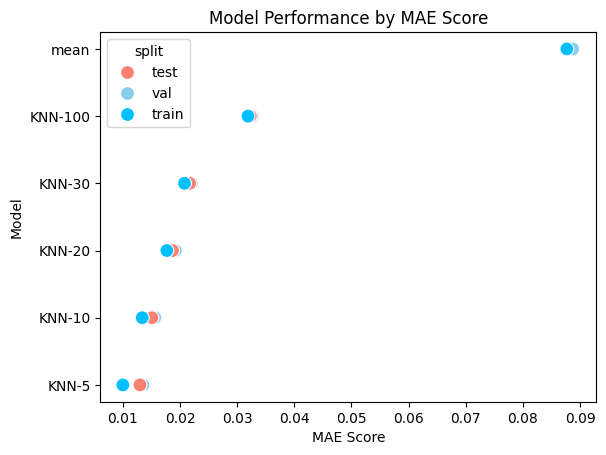

In [21]:
# Make scatterplot of mae
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                     y='model', 
                     x='mae', 
                     marker='o',   # Circle markers
                     s=100,        # Size of the markers
                     hue='split',  # Color by split
                     palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by MAE Score')

# Adding x and y axis labels
plt.xlabel('MAE Score')
plt.ylabel('Model')
# Save plot
plt.savefig(('../plots/base_models_MAE.png'))
# Display the plot
plt.show()

# Un normalise

In [25]:
scaler_y = joblib.load('../data/scaler_y.joblib')
original = []

# Load model
knn = KNeighborsRegressor(n_neighbors=5)
# Fit model
knn.fit(X_train, y_train)
# Zip data and labels
for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
    # Make predictions                
    preds = knn.predict(x)
    # Inverse transform normalized predictions
    preds_original = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    # Inverse transform true values
    y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
    # Get MAE
    mae = mean_absolute_error(y_original, preds_original)
    # Append to performances
    original.append({
        'model': 'KNN-5',
        'split': nsplit,
        'mae': mae.round(4),
        'preds': preds_original,
        'y': y_original
    })

# Print MAE values

In [34]:
# Define the models and splits we are interested in
models_of_interest = ['KNN-5']
splits_of_interest = ['train', 'val', 'test']

# Header for the output
print(f"{'Model':<10} | {'Split':<5} | {'MAE':>5}")

# Loop through each model and split to print the MAE scores
for model in models_of_interest:
    for split in splits_of_interest:
        # Find the relevant performance entry
        entry = next((item for item in original if item['model'] == model and item['split'] == split), None)
        if entry is not None:
            # Print the model, split, and MAE score
            print(f"{model:<10} | {split:<5} | {entry['mae']:>5.4f}")
        else:
            # Handle cases where no entry is found
            print(f"{model:<10} | {split:<5} | {'N/A':>5}")


Model      | Split |   MAE
KNN-5      | train | 14.6387
KNN-5      | val   | 19.7137
KNN-5      | test  | 18.9493


# Predictions of best model (KNN-5)

In [38]:
preds = original[2]['preds']
y = original[2]['y']


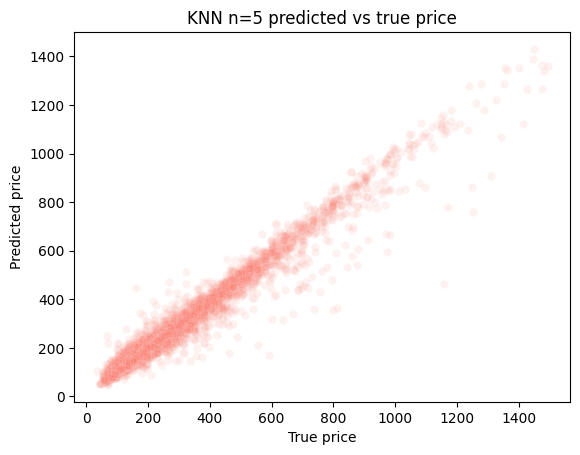

In [39]:
# Make scatterplot of prd vs true values
sns.scatterplot(x=y, y=preds, color='salmon', alpha=0.1)
plt.title('KNN n=5 predicted vs true price')
plt.xlabel('True price')
plt.ylabel('Predicted price')
# Save plot
plt.savefig(('../plots/KNN5_prdicted_true.png'))
plt.show()

Big tendency to undervalue!

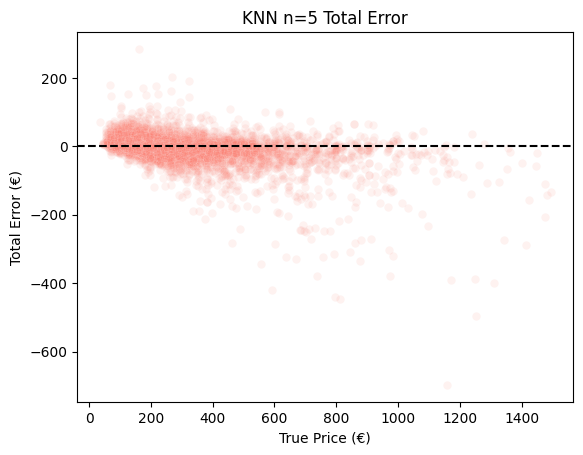

In [53]:
# Calculation of total error
total_error = preds - y

# Create scatter plot of predictions vs true values
sns.scatterplot(x=y, y=total_error, color='salmon', alpha=0.1)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

# Set the title and labels of the plot
plt.title('KNN n=5 Total Error')
plt.xlabel('True Price (€)')
plt.ylabel('Total Error (€)')

# Show the plot
plt.show()

In [50]:
# Count how many values in total_error are greater than 18 euros in absolute terms
count_off_by_18 = np.sum(np.abs(total_error) > 18)

# Print the result
print(f"{count_off_by_18} of the predictions were more than 18 euro off.")

2295 of the predictions were more than 18 euro off.


# OBS ON WHAT DATA IS IN BELOW

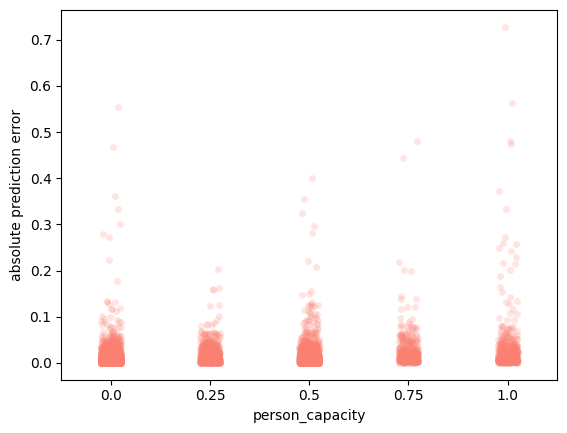

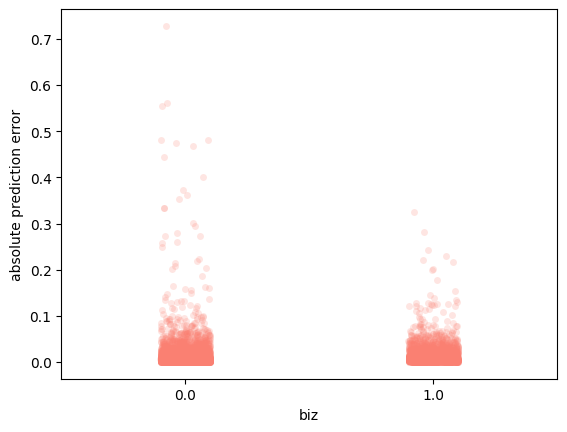

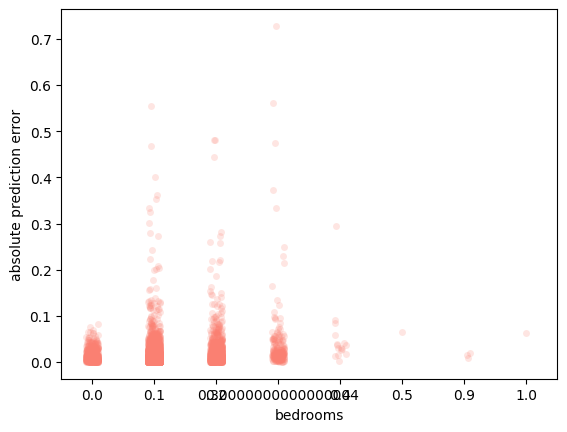

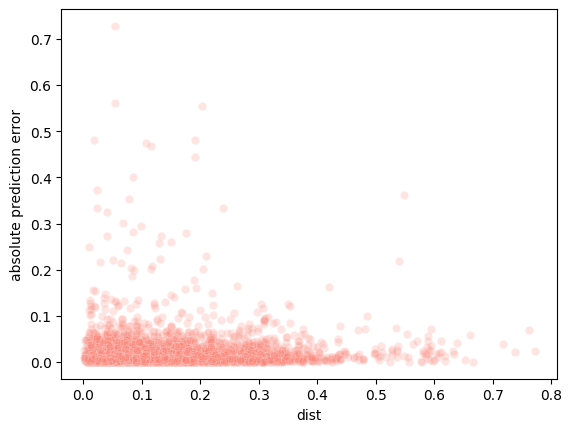

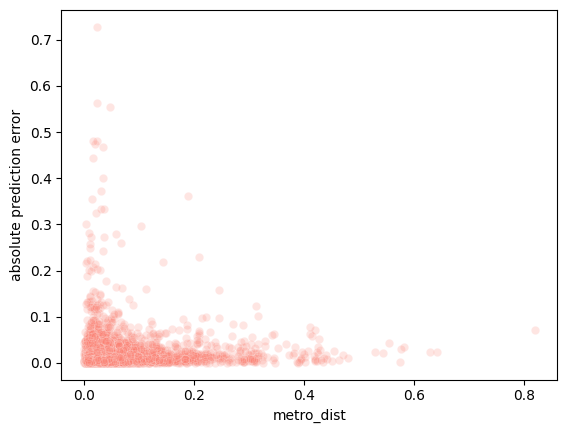

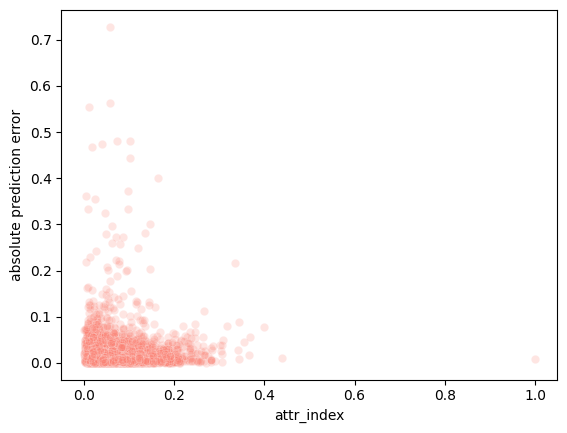

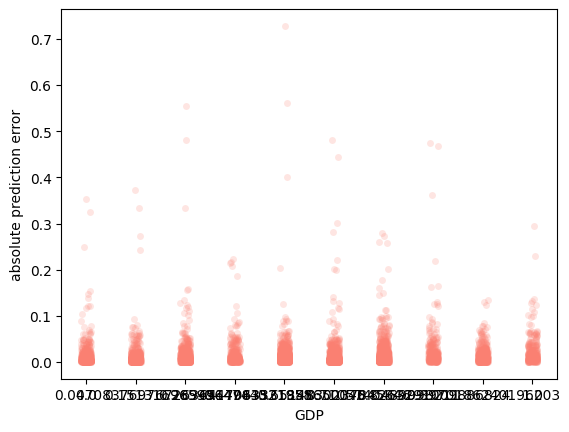

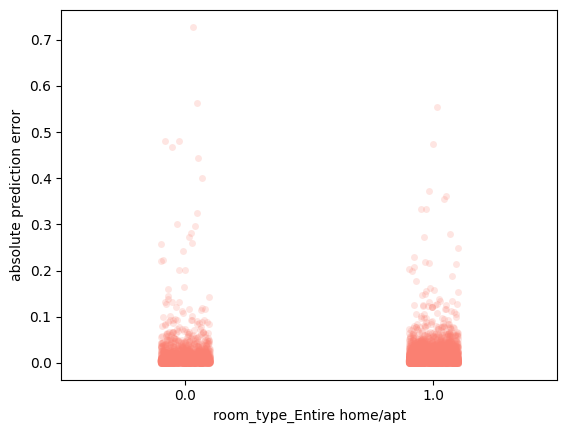

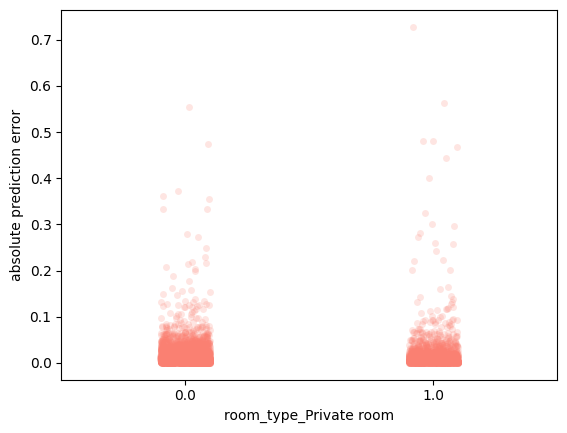

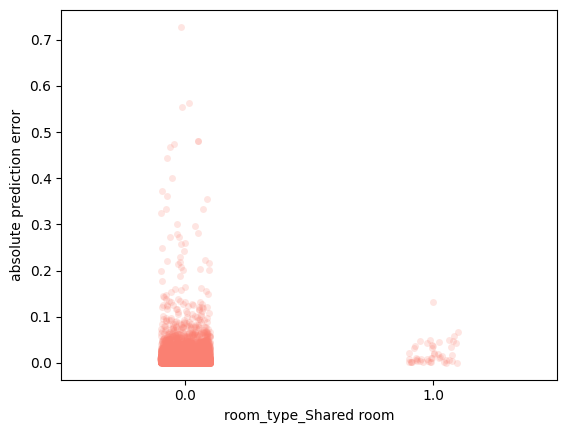

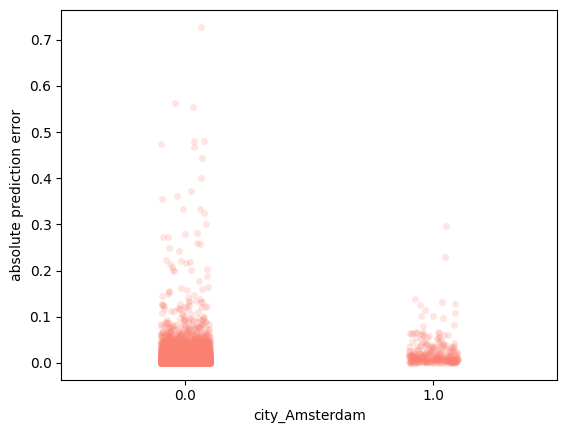

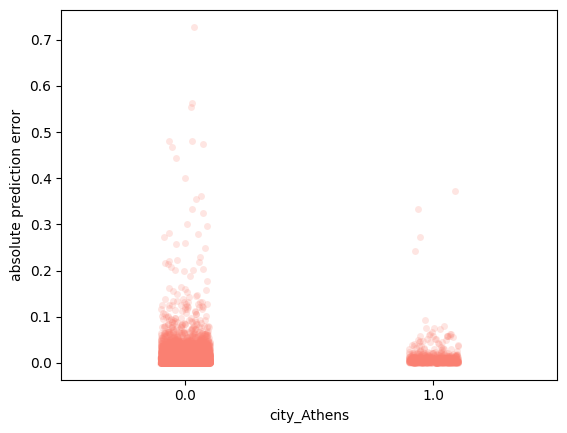

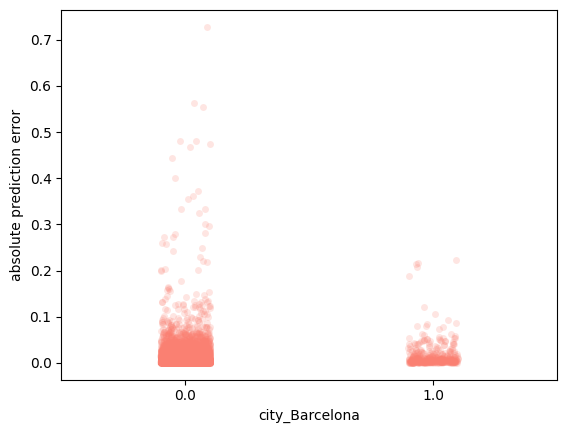

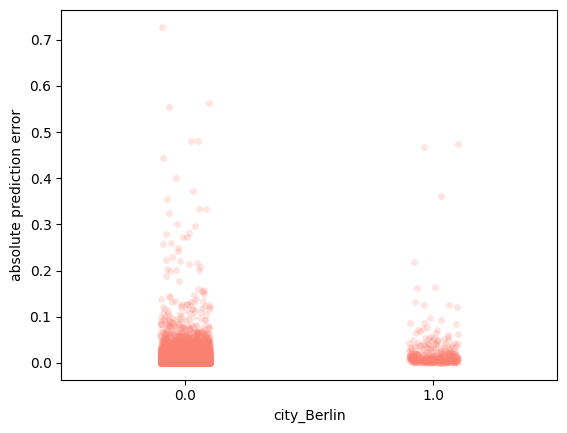

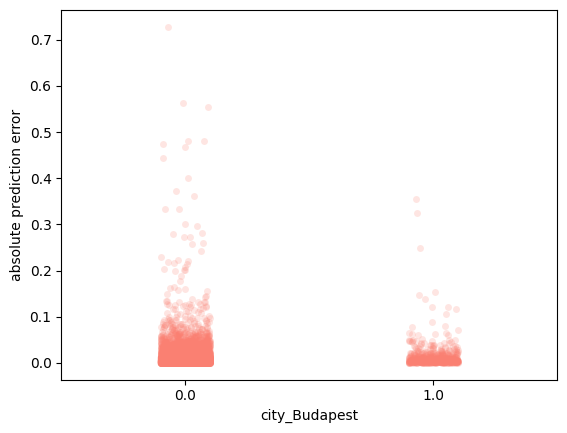

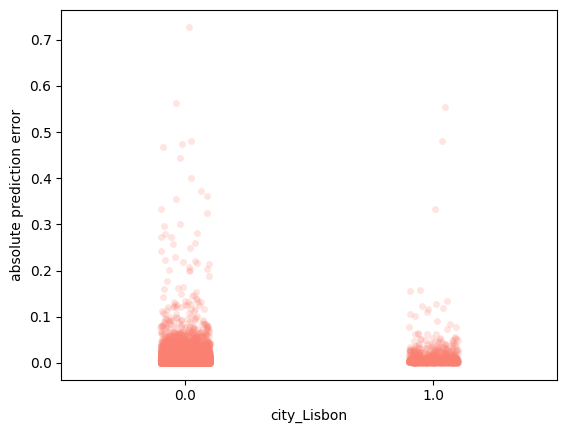

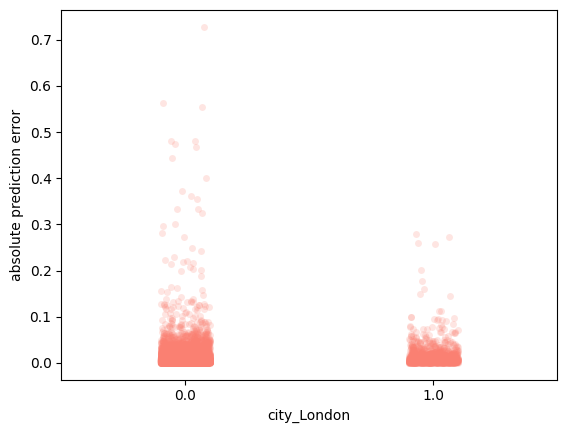

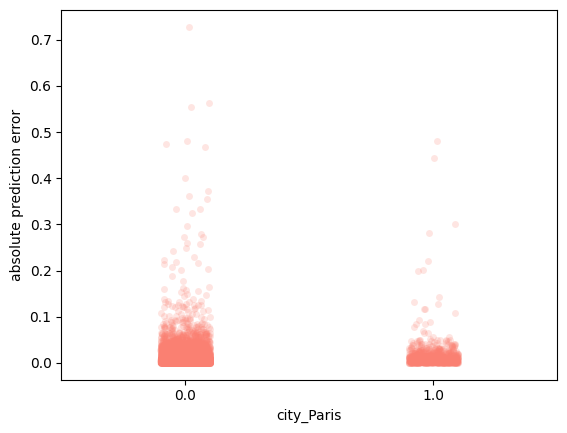

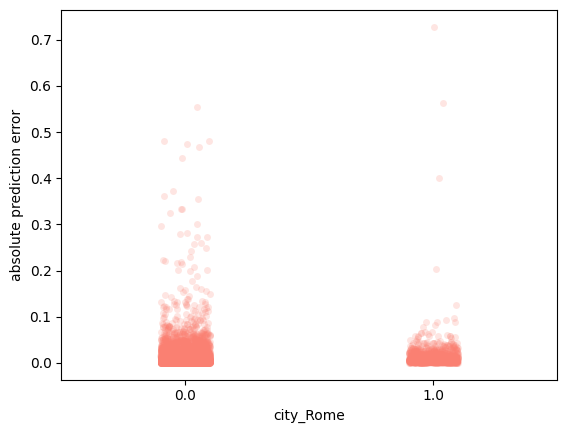

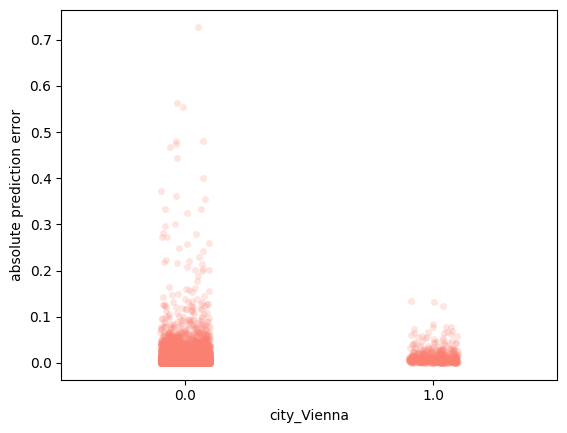

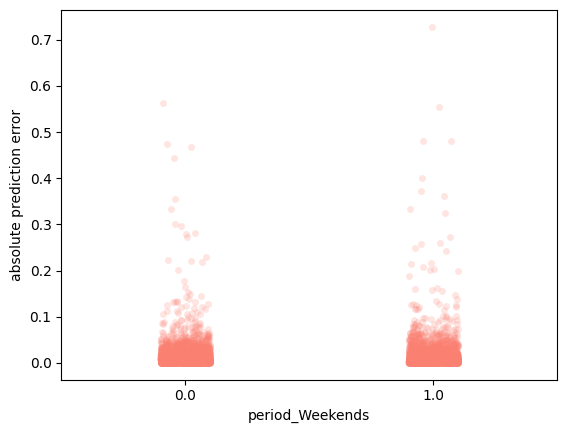

In [31]:
absolute_error = np.abs(best_preds - y_val)

cat = [
 'person_capacity',
 'biz',
 'bedrooms',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'city_Amsterdam',
 'city_Athens',
 'city_Barcelona',
 'city_Berlin',
 'city_Budapest',
 'city_Lisbon',
 'city_London',
 'city_Paris',
 'city_Rome',
 'city_Vienna',
 'period_Weekends',
 'GDP'
 ]
num = [
 'dist',
 'metro_dist',
 'attr_index']   

for i in range(len(column_names)):
    if column_names[i] in cat:
        sns.stripplot(x=X_val[:,i], y=absolute_error, color='salmon', alpha=0.2)
        plt.xlabel(column_names[i])
        plt.ylabel('absolute prediction error')
        plt.show()
    elif column_names[i] in num:
        sns.scatterplot(x=X_val[:,i], y=absolute_error, color='salmon', alpha=0.2)
        plt.xlabel(column_names[i])
        plt.ylabel('absolute prediction error')
        plt.show()
        